In [1]:
from fastai.vision import *
import glob
import os
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from fastai.vision import *

In [2]:
path = Path('All images/')

In [3]:
df = pd.read_csv('All images/label list.csv', sep=',')

In [4]:
tfms = get_transforms(max_rotate=30, max_zoom=1.3, max_lighting=0.4, max_warp=0.,
                     p_affine=1., p_lighting=1.)

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, label_delim='|', 
                               csv_labels='label list.csv', label_col=1, delimiter=',', valid_pct=0.2,
                              ds_tfms=tfms, bs=64, size=224, num_workers=3).normalize()

In [6]:
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
head_reg = nn.Sequential(Flatten(),
                        nn.Linear(50176,data.c)
                        )

In [7]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta=1)

In [8]:
learner = cnn_learner(data, models.vgg16_bn, pretrained=False, metrics=[acc_02, f_score],
                     loss_func=loss_func)

In [9]:
learner.to_fp16();

In [10]:
learner.unfreeze()

In [11]:
@dataclass
class wd_finder:
    learn: Learner
    wd:Union[int,Callable] = None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0,1e-1,1e-3,1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd,**kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='WD={}'.format(self.wd_list[k]))
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.set_xscale('log')

In [12]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02


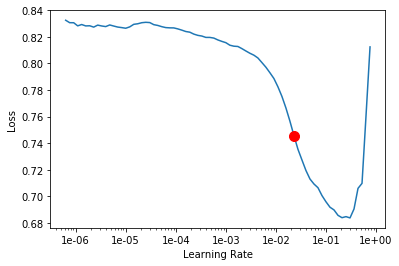

In [13]:
learner.recorder.plot(suggestion=True)

In [14]:
find_wd = wd_finder(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


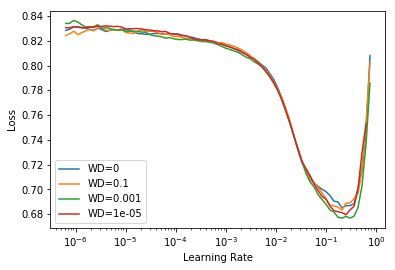

In [15]:
find_wd.plot_wd()
#plt.title('DenseNet-121 WG')
#plt.savefig('WD_find_DenseNet-121-WG.png')

In [16]:
find_wd2 = wd_finder(learner,wd=(1e-5,1e-6,1e-7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


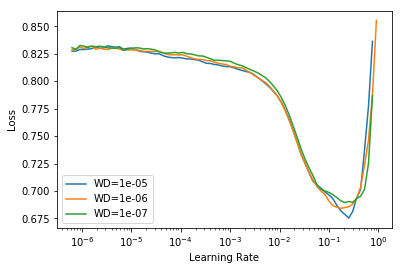

In [17]:
find_wd2.plot_wd()